In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy, pickle

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')

from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import cost_functions as cost_functions
from neurolib.optimal_control import oc_wc

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [9]:
def gettarget(targetstate):
    target = np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]
    target[0,0,:] = targetstate[0]
    target[0,1,:] = targetstate[1]

    return target

def setinit(initstate):
    wc.params["exc_init"] = np.array([[ initstate[0] ]])
    wc.params["inh_init"] = np.array([[ initstate[1] ]])

def decrease_step_compute():

    for pow in [-4, -5]:

        wc_controlled.step = 10**pow
        wc_controlled.zero_step_encountered = False
        wc_controlled.optimize(200)

def increase_step_compute():

    for pow in [-2, -1, 0, 2, 4]:

        wc_controlled.step = 10**pow
        wc_controlled.zero_step_encountered = False
        wc_controlled.optimize(200*(3 + pow))

    return

def get_values(results_dict, ip, w):
    results_dict["control"][ip] = wc_controlled.control.copy()
    results_dict["state"][ip] = wc_controlled.get_xs().copy()
    results_dict["cost"][ip] = wc_controlled.cost_history[-1]

    wc_controlled.w_1D = 0.
    wc_controlled.simulate_forward()
    results_dict["precision_cost"][ip] = wc_controlled.compute_total_cost()
    wc_controlled.w_1D = w

    ce = np.zeros((results_dict["control"][ip].shape))
    ce[0,0,:] = results_dict["control"][ip][0,0,:]
    results_dict["L_cost"][ip][0] = cost_functions.energy_cost(ce, 1., dt)
    ci = np.zeros((results_dict["control"][ip].shape))
    ci[0,1,:] = results_dict["control"][ip][0,1,:]
    results_dict["L_cost"][ip][1] = cost_functions.energy_cost(ci, 1., dt)

    return

def getmodel(t, w, results_dict, i):
    wc_controlled = oc_wc.OcWc(wc, target=t, w_p=1, w_2=w, w_1D=0., print_array=[], precision_cost_interval=(int0,None), control_matrix=control_mat, precision_matrix=prec_mat)

    if type(results_dict["control"][i]) != type(None):
        wc_controlled.control = results_dict["control"][i].copy()
        wc_controlled.update_input()
    wc_controlled.model.run()    

    return wc_controlled


In [10]:
duration_array = np.array( [22, 25, 28, 36, 60, 100])
n_times = len(duration_array)
fname = 'w2_du_T'

results_w2_du = dict([
    ('cost_type', 'w1'),
    ('d', [None] * n_times),
    ('u', [None] * n_times),
    ("cost", [None] * n_times),
    ("initial_cost", [None] * n_times),
    ("precision_cost", [None] * n_times),
    ("L_cost", [np.zeros((2))] * n_times),
    ("control", [None] * n_times),
    ("state", [None] * n_times),
    ])

def save(res, file):
    filehandler = open( (file + ".pickle"),"wb")
    pickle.dump(res,filehandler)
    filehandler.close()

In [69]:
with open('w2_du_T.pickle', 'rb') as f:
    results_w2_du = pickle.load(f)

In [11]:
points_bi = [ [2.9, 2.9]]

wc = WCModel()
wc.params.sigma_ou = 0.
dt = 0.1
wc.params.dt = dt
duration = 500.
wc.params["duration"] = duration

zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
bi_control = zero_input.copy()
bi_control[0,:500] = -5.
bi_control[0,2500:3000] = +5.

p = points_bi[0]

wc.params["exc_ext"] = bi_control + p[0]
wc.params["inh_ext"] = zero_input + p[1]
wc.run()

for i in range(len(duration_array)):
    results_w2_du['d'][i] = [wc.exc[0,2000], wc.inh[0,2000]]
    results_w2_du['u'][i] = [wc.exc[0,-1], wc.inh[0,-1]]

In [18]:
w1 = 1.
duration_array[-1] = 80.

control_mat = np.zeros( (wc.params.N, len(wc.state_vars)) )
control_mat[0,0] = 1.
control_mat[0,1] = 1.

prec_mat = np.zeros( (wc.params.N, len(wc.output_vars)) )
prec_mat[0,0] = 1.
prec_mat[0,1] = 1.

for i in range(len(duration_array)):

    duration = duration_array[i]
    wc.params["duration"] = duration
    zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)

    int0 = np.around(duration/dt).astype(int) - 200

    print("DURATION ", duration_array[i], int0)

    wc.params["exc_ext"] = zero_input + p[0]
    wc.params["inh_ext"] = zero_input + p[1]

    target = gettarget( results_w2_du['u'][i] )
    setinit( results_w2_du['d'][i] )

    #if type(results_w1_du["control"][i]) != type(None):
    #    continue

    #results_w2_du["control"][i] = None
    wc_controlled = getmodel(target, w1, results_w2_du, i)

    #wc_controlled.control[0,0,:200] = results_w1_du["control"][i-1][0,0,:200]

    if type(results_w2_du["control"][i]) == type(None):

        wc_controlled.step = 1e-3
        wc_controlled.optimize(1)

        results_w2_du["initial_cost"][i] = wc_controlled.cost_history[0]

        wc_controlled.control[0,0,-300:-200] = 5.
        wc_controlled.update_input()

        wc_controlled.step = 1e-2
        wc_controlled.optimize(100)

        increase_step_compute()

        wc_controlled.optimize(0)    
        get_values(results_w2_du, i, w1)

        continue

    itmax = int(duration)

    for k in range(itmax):
        print(k)
        c0 = np.zeros((wc_controlled.control.shape))
        c0[0,:,:-20] = wc_controlled.control[0,:,20:]
        wc_controlled.control = c0.copy()
        wc_controlled.update_input()
        wc_controlled.optimize(0)

        wc_controlled.step =  10**(-12)
        wc_controlled.step_factor = 0.8
        wc_controlled.optimize(100)

        decrease_step_compute()

        wc_controlled.step =  10**(-16)
        wc_controlled.step_factor = 0.8
        wc_controlled.optimize(100)

        decrease_step_compute()

        wc_controlled.step =  10**(-20)
        wc_controlled.step_factor = 0.8
        wc_controlled.optimize(100)

        decrease_step_compute()

        if results_w2_du["cost"][i] > wc_controlled.cost_history[-1]:
            get_values(results_w2_du, i, w1)
        else: break
    
    for k in range(100):
        print(k)
        c0 = np.zeros((wc_controlled.control.shape))
        c0[0,:,:-1] = wc_controlled.control[0,:,1:]
        wc_controlled.control = c0.copy()
        wc_controlled.update_input()
        wc_controlled.optimize(0)

        wc_controlled.step =  10**(-12)
        wc_controlled.step_factor = 0.8
        wc_controlled.optimize(100)

        decrease_step_compute()

        wc_controlled.step =  10**(-22)
        wc_controlled.step_factor = 0.8
        wc_controlled.optimize(100)

        decrease_step_compute()

        if results_w2_du["cost"][i] > wc_controlled.cost_history[-1]:
            get_values(results_w2_du, i, w1)
        else: break

    save(results_w2_du, fname)

DURATION  22 20
0
Compute control for a deterministic system
Cost in iteration 0: 2.917717395412651
Final cost : 2.917717395412651
Compute control for a deterministic system
Cost in iteration 0: 2.917717395412651
Final cost : 2.9177173953881805
Compute control for a deterministic system
Cost in iteration 0: 2.9177173953881805
Final cost : 2.9129141224446435
Compute control for a deterministic system
Cost in iteration 0: 2.9129141224446435
Final cost : 2.912443719214762
Compute control for a deterministic system
Cost in iteration 0: 2.912443719214762
Final cost : 2.9124437192147594
Compute control for a deterministic system
Cost in iteration 0: 2.9124437192147594
Final cost : 2.9078360146133004
Compute control for a deterministic system
Cost in iteration 0: 2.9078360146133004
Final cost : 2.907384775225043
Compute control for a deterministic system
Cost in iteration 0: 2.907384775225043
Converged in iteration 1 with cost 2.907384775225043 because of vanishing difference
Final cost : 2.9

duration  22
amplitude =  1.5616502450194014
1.5808676962057715 0.7907068465975502 2.794785708126736


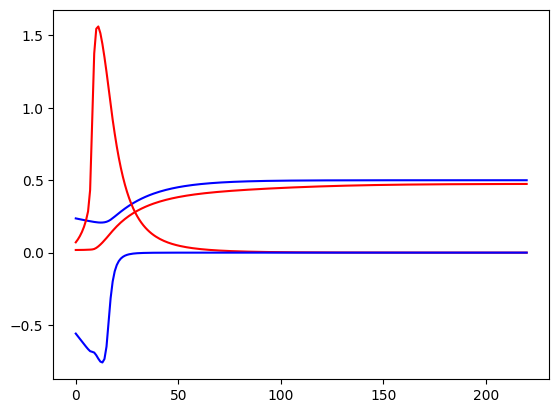

duration  25
amplitude =  1.3847469023770886
1.40148696916405 0.7907068465975502 2.794785708126736


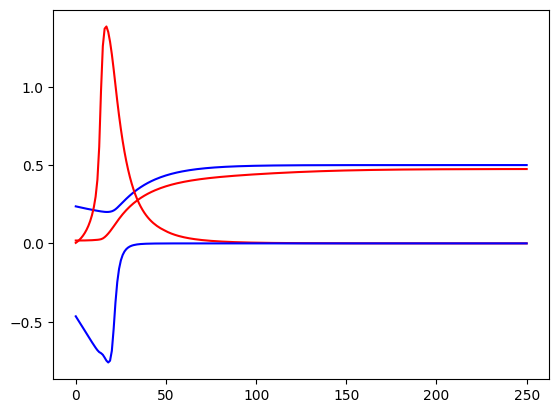

duration  28
amplitude =  1.357761192605506
1.3645615664251394 0.7907068465975502 2.794785708126736


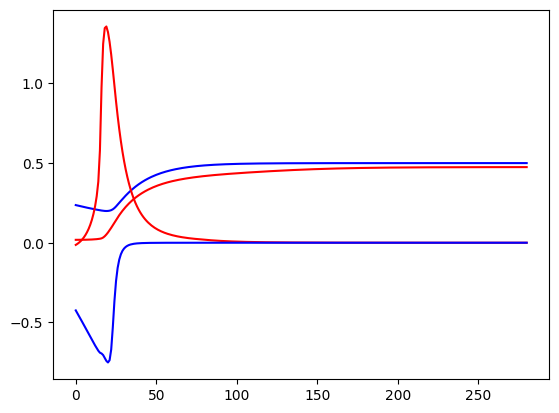

duration  36
amplitude =  1.2720469744982188
1.2616615025600066 0.7907068465975502 2.794785708126736


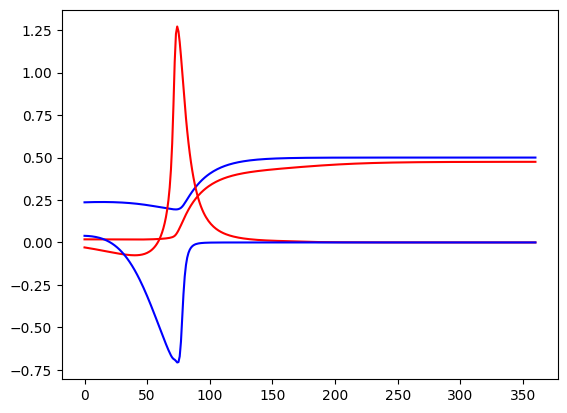

duration  60
amplitude =  1.2165255165027289
1.2568572625857597 0.7907068465975502 2.794785708126736


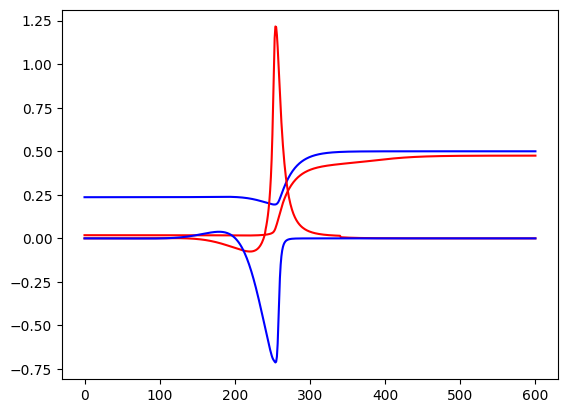

duration  80
amplitude =  1.2341645634805187
1.2616725912305764 0.7907068465975502 2.794785708126736


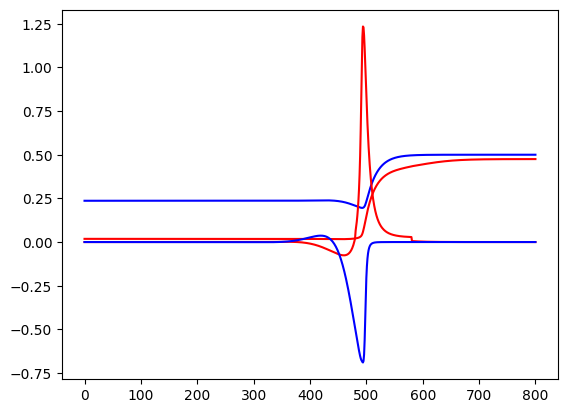

In [19]:
for i in range(len(duration_array)):
    print("duration ", duration_array[i])
    print("amplitude = ", np.amax(results_w2_du["control"][i]))
    
    print(results_w2_du["cost"][i], results_w2_du["L_cost"][i][0], results_w2_du["initial_cost"][i])
    plt.plot(results_w2_du["state"][i][0,0,:], color="red", linestyle='-')
    plt.plot(results_w2_du["state"][i][0,1,:], color="blue", linestyle='-')
    plt.plot(results_w2_du["control"][i][0,0,:], color="red")
    plt.plot(results_w2_du["control"][i][0,1,:], color="blue")
    plt.show()

In [21]:
save(results_w1_du, fname)

In [19]:
fname = 'w1_du_T'